In [337]:
import mne
import os
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne.preprocessing import read_ica
from BCOM_processing.SCRIPTS.functions import Preprocessing
from datahandling import BcomMEG
from wavelets import *

In [24]:
#################################
# same filtering as the epochs #
#################################
# filtering
lowpass=150.#for ERPs and
highpass=0.5#high-pass filtering of MEG is iffy and to be done with caution, better to de-trend epochs. Espaciall bad for MVPA, 0.05 should eb safe, rememebr you might already have high-passed during MF stage. In this case leave 0
ICA_method='fastica'
n_components = 25  #of ICA decomposition
decim = 3  # we need sufficient statistics, not all time points -> saves time
reject = dict(mag=5e-12)#reject spurious activity, should not be a lot since we MF-ed
bad_loc_chan = 'MEG 173' # bad chan to be removed
# set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this is run
random_state = 23

In [454]:
processed_raw = mne.io.read_raw("/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/PREPROCESSED/BCOM_06/2/cleaned_raw.fif")
kept_channels = processed_raw.ch_names
print(kept_channels)
bad_channels = processed_raw.info['bads']
print(bad_channels)

Opening raw data file /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/PREPROCESSED/BCOM_06/2/cleaned_raw.fif...
    Range : 0 ... 213874 =      0.000 ...   712.913 secs
Ready.
['MEG 001', 'MEG 002', 'MEG 003', 'MEG 004', 'MEG 005', 'MEG 006', 'MEG 007', 'MEG 008', 'MEG 009', 'MEG 010', 'MEG 011', 'MEG 012', 'MEG 013', 'MEG 014', 'MEG 015', 'MEG 016', 'MEG 017', 'MEG 018', 'MEG 019', 'MEG 020', 'MEG 021', 'MEG 022', 'MEG 023', 'MEG 024', 'MEG 025', 'MEG 026', 'MEG 027', 'MEG 028', 'MEG 029', 'MEG 030', 'MEG 031', 'MEG 032', 'MEG 033', 'MEG 034', 'MEG 035', 'MEG 036', 'MEG 037', 'MEG 038', 'MEG 039', 'MEG 040', 'MEG 041', 'MEG 042', 'MEG 043', 'MEG 044', 'MEG 045', 'MEG 046', 'MEG 047', 'MEG 048', 'MEG 049', 'MEG 050', 'MEG 051', 'MEG 052', 'MEG 053', 'MEG 054', 'MEG 055', 'MEG 056', 'MEG 057', 'MEG 058', 'MEG 059', 'MEG 060', 'MEG 061', 'MEG 062', 'MEG 063', 'MEG 064', 'MEG 065', 'MEG 066', 'MEG 067', 'MEG 068', 'MEG 069', 'MEG 070', 'MEG 071', 'MEG 072', 'MEG 073', 'MEG 074', 'ME

In [456]:
unprocessed_raw = mne.io.read_raw_bti('/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_06/MEG/BCOM_06/BCom/04%17%19@00_34/2/c,rfDC')
unprocessed_raw.plot()

Reading 4D PDF file /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_06/MEG/BCOM_06/BCom/04%17%19@00_34/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... Reading digitization points from /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_06/MEG/BCOM_06/BCom/04%17%19@00_34/2/hs_file
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [455]:
processed_raw.plot()

Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [448]:
assert "MEG 059" in processed_raw.info['ch_names']

processed_raw.info['bads']

for i, ch in enumerate(processed_raw.info['ch_names']):
    if "059" in ch:
        print(i, ch)

58 MEG 059


Reading 4D PDF file /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_06/MEG/BCOM_06/BCom/04%17%19@00_34/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... Reading digitization points from /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_06/MEG/BCOM_06/BCom/04%17%19@00_34/2/hs_file
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 1450434  =      0.000 ...   712.916 secs...
Trigger channel STI 014 has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1053 events found on stim channel STI 014
Event IDs: [  2   4  12  14  16  22  24  26  32  34  36  42  44  46  52  54  56  62
  64  66 112 114 116 122 124 12

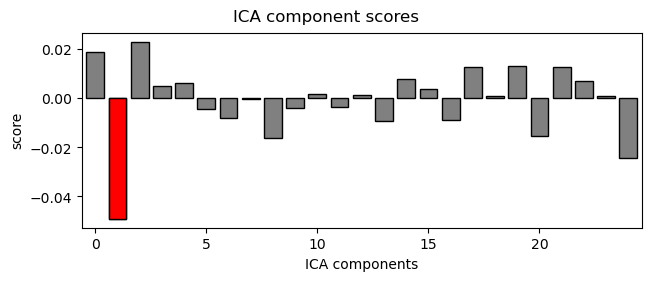

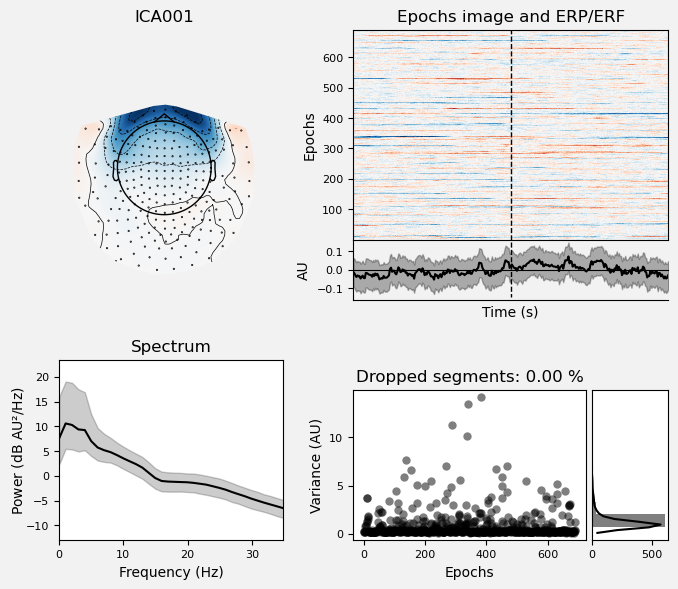

In [27]:
raw_ica = mne.io.read_raw_bti('/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_06/MEG/BCOM_06/BCom/04%17%19@00_34/2/c,rfDC', preload=True)

raw_ica.resample(300) #NB! this particular version of resample is on the output of the previous line.
        

raw_ica.filter(highpass, None, n_jobs=1, fir_design='firwin') #applies a filter a 0.5 for the lower pass-band edge. (wait what exactly does this mean?)

Prep = Preprocessing(raw_ica) 

outliers = Prep.get_outliers() 
        

flats = Prep.get_flatlines(MaxFlatlineDuration=60, MaxAllowedJitter=1e-5) 

bad_chans = [x for x in outliers] #initialize the bad channels list with the outliers

for flat in flats: #loop through the flat channels
    if flat not in bad_chans: #if the flat channel is not already in the bad channels list
        bad_chans.append(flat) #add it to the bad channels list
    if bad_loc_chan in bad_chans: #if the localizer channel is in the bad channels list
        bad_chans.remove(bad_loc_chan) #remove it from the bad channels list
    bad_chans.sort() #sort the bad channels list

raw_ica.info['bads'] = bad_chans #set the bad channels in the raw data object to the bad channels list

        # setup and do ICA
ica = ICA(n_components=n_components, method=ICA_method, #at least in this iteration, uses fast ica
            random_state=random_state)  # define ica object with selected parameters

excluded_chans = [x for x in raw_ica.info['bads']] #initialize the excluded channels list with the bad channels. Don't we already have this
        # though in bad_chans? maybe there is more data in raw_ica.info['bads'] than in bad_chans?

excluded_chans.append(bad_loc_chan) #and then we add back the bad_loc_chan? which we removed earlier? Why?

        # now we pick the channels that we want to use for ICA
picks = mne.pick_types(raw_ica.info, meg=True, eeg=False, stim=False, eog=False, ecg=False, misc=False, exclude=excluded_chans)
        # we only take the MEG channels, and exclude the bad channels (including the localizer channel)

        # fit the ICA
ica.fit(raw_ica, picks=picks, decim=decim, reject=reject) #takes the raw data, the picks, the decimation factor, and the type of activity to reject
        # and fits the ICA to the data

EOG_chan = raw_ica.info['ch_names'][-10] # isolate the EOG channel

eog_epochs = create_eog_epochs(raw_ica, ch_name=EOG_chan, reject=reject)  # get single EOG trials eog_epochs = create_eog_epochs(rawica, ch_name=None, reject=reject)# get single EOG trials if No EOG chan
eog_inds, scores = ica.find_bads_eog(eog_epochs,
                                        ch_name=EOG_chan)  # find via pearson correlation; eog_inds, scores = ica.find_bads_eog(eog_epochs,ch_name=None)# if No EOG chan, then manually select the component that looks like blink


        #this is also a plot, but a plot of the eog properties?
for eog in eog_inds:
    eog_prop = ica.plot_properties(eog_epochs, picks=eog, psd_args={'fmax': 35.}, image_args={'sigma': 1.}, # psd_args refers to the Power Spectral Density plot, setting the max frequency of 35Hz
                                           show=False) # image_args refers to the Gaussian smoothing for the image, being set to 

        # remove the top horizontal EOG component - why do we want to do this?
EOG_chan_h = raw_ica.info['ch_names'][-5] #again, isolate channel

eog_epochs_h = create_eog_epochs(raw_ica, ch_name=EOG_chan_h, reject=reject) #same idea, create epochs

eog_h_inds, scores = ica.find_bads_eog(eog_epochs_h, ch_name=EOG_chan_h) #find the bads

eog_hscoresplot = ica.plot_scores(scores, exclude=eog_h_inds, show=False) # why are these h_scores ratehr than r_scores? Is it because they are horizontal?


if len(eog_h_inds) >= 1:
    eog_h_inds = [eog_h_inds[0]]  # keep only the first one
    eog_h_prop = ica.plot_properties(eog_epochs_h, picks=eog_h_inds[0], psd_args={'fmax': 35.},
                                             image_args={'sigma': 1.}, show=False)

     
ECG_chan = raw_ica.info['ch_names'][-9] #isolate the ECg channel

ecg_epochs = create_ecg_epochs(raw_ica, ch_name=ECG_chan, tmin=-.5, tmax=.5, picks=picks) #so this one is a bit different in that it has different parameters!
        # tmin -> the start time before the event; tmax -> the end time after the event; picks -> the channels to include

ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, method='ctps') #NB! uses 'cross trial phase statistics'

        # same plotting as before
for ecg in ecg_inds:
    ecg_prop = ica.plot_properties(ecg_epochs, picks=ecg, psd_args={'fmax': 35.}, image_args={'sigma': 1.},
                                           show=False)

In [28]:
exclude = list(set(eog_inds + eog_h_inds + ecg_inds))
print(exclude)

[1]


In [436]:
empty_room_recording = mne.io.read_raw_bti('/Volumes/BCOM/BCOM/DATA_RAW/BCOM_04/MEG/BCOM_04/emp_sup_v1/04%16%19@02_51/2/c,rfDC', 
                                           head_shape_fname=None,
                                           preload=True)

Reading 4D PDF file /Volumes/BCOM/BCOM/DATA_RAW/BCOM_04/MEG/BCOM_04/emp_sup_v1/04%16%19@02_51/2/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 366211  =      0.000 ...   180.000 secs...


In [450]:
empty_room_recording.info['bads']
# empty_room_recording.plot()

['MEG 059']

Using up to 900 segments
Number of samples used : 366300
[done]
Computing rank from covariance with rank=None
    Using tolerance 3.9e-11 (2.2e-16 eps * 247 dim * 7.2e+02  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 247 data channels with 0 projectors


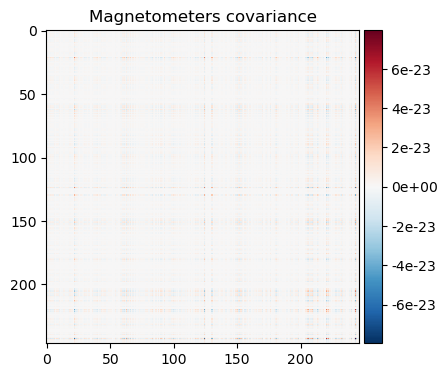

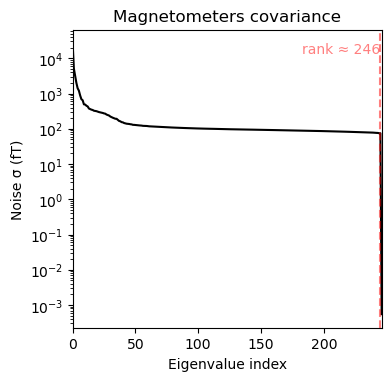

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [440]:
noise_cov = compute_raw_covariance(empty_room_recording.pick([ch for ch in empty_room_recording.ch_names if ("173" not in ch) or ("059" not in ch)]))
noise_cov.plot(empty_room_recording.info)

Effective window size : 1.007 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


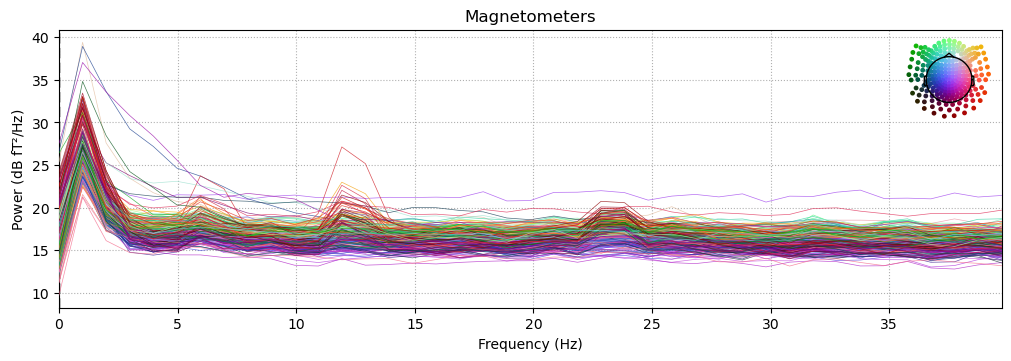

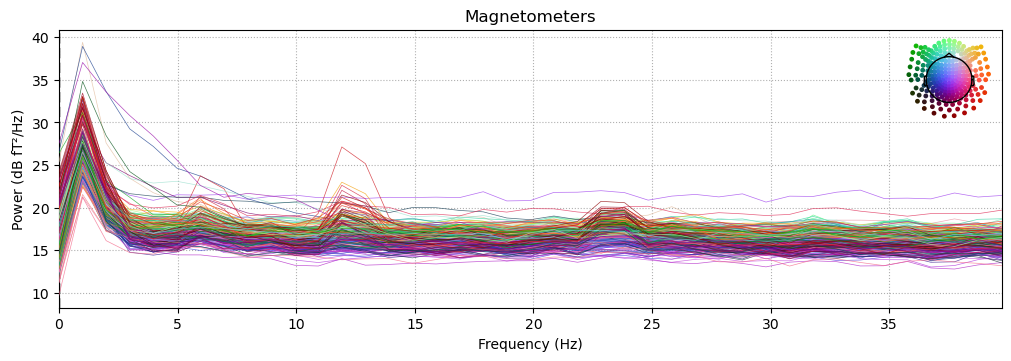

In [438]:
empty_room_recording.info['bads'].append("MEG 059")

empty_room_recording.copy().drop_channels(["MEG 059", "MEG 173"]).compute_psd(fmax=40).plot()

In [281]:
empty_room_recording.plot()

Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [288]:
ica = read_ica("/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/PREPROCESSED/BCOM_06/2/ICA/solution_ica.fif")

empty_room_recording = mne.io.read_raw_bti('/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_06/MEG/BCOM_06/emp_sup_v1/04%17%19@00_00/1/c,rfDC', 
                                           head_shape_fname=None,
                                           preload=True)

empty_room_recording.filter(h_freq=highpass, l_freq=lowpass, n_jobs=1, fir_design='firwin')
empty_room_recording.resample(300)


# empty_room_recording_clean = ica.apply(empty_room_recording.copy(), exclude=exclude)

empty_room_recording.drop_channels(bad_loc_chan)





empty_room_recording.info['bads']=bad_channels
empty_room_recording.info['bads'].append("MEG 059")



Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/PREPROCESSED/BCOM_06/2/ICA/solution_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading 4D PDF file /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_RAW/BCOM_06/MEG/BCOM_06/emp_sup_v1/04%17%19@00_00/1/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... putting coil transforms in Neuromag coordinates
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Reading 0 ... 141287  =      0.000 ...    69.445 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 pa

RuntimeError: Cannot fit headshape without digitization, info["dig"] is None

In [293]:
from mne import compute_raw_covariance
noise_cov = compute_raw_covariance(empty_room_recording, 
                                   method='auto',
                                   rank=None, 
                                   picks="meg")

Using up to 347 segments
Using data from preloaded Raw for 347 events and 60 original time points ...
0 bad epochs dropped
Reducing data rank from 246 -> 246
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 20820
log-likelihood on unseen data (descending order):
   shrunk: -1535.775
   diagonal_fixed: -1676.197
   empirical: -3874.137
selecting best estimator: shrunk
[done]


In [294]:
print(noise_cov)
import numpy as np
print("Max:", np.max(noise_cov.data))
print("Min:", np.min(noise_cov.data))
print("Mean:", np.mean(noise_cov.data))
print("Non-zero entries:", np.count_nonzero(noise_cov.data))
print("Total number of entries", noise_cov.data.shape[0]*noise_cov.data.shape[1])

<Covariance | kind : full, shape : (246, 246), range : [-7.6e-24, +1.1e-23], n_samples : 20819>
Max: 1.1295345615476157e-23
Min: -7.572978476987082e-24
Mean: 1.3162669337145614e-25
Non-zero entries: 60516
Total number of entries 60516


Computing rank from covariance with rank=None
    Using tolerance 6.2e-12 (2.2e-16 eps * 246 dim * 1.1e+02  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors


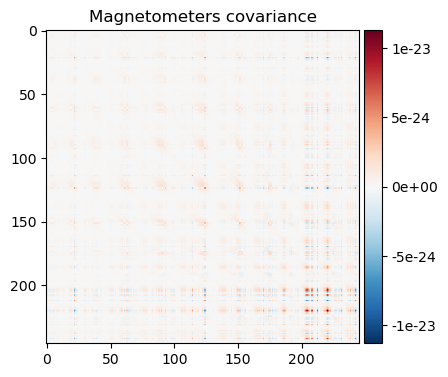

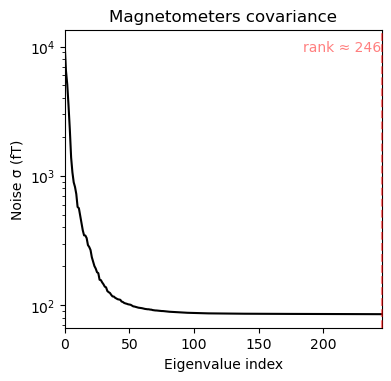

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [295]:
mne.viz.plot_cov(noise_cov, empty_room_recording.info)

## Reconstruction

In [269]:
scaled = "scaled_fsaverage"
subject = "BCOM_18_2"

In [270]:
morphed_bem = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-5120-5120-5120-bem-sol.fif"
morphed_source = f"/Users/ciprianbangu/mne_data/MNE-fsaverage-data/{scaled}_{subject}/bem/{scaled}_{subject}-ico-5-src.fif"
morphed_trans = f"/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/{subject}-trans.fif"


fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

0 files missing from root.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage


In [271]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
subjects = [subject]
picks = None

data = BcomMEG(dir=dir, subjects=subjects, picks=picks, avoid_reading=False, avoid_producing=True)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_16-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_me_34-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_sa_52-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
13 matching events found
No baseline correcti

In [306]:
evoked_reading = data.data[subject]['sa_52']
print(evoked_reading)

for syllable, epochs in data.data[subject].items():
    if syllable != "sa_52":
        evoked_reading = mne.concatenate_epochs((evoked_reading, epochs))

# evoked_reading = evoked_reading.copy().apply_baseline((-0.2,0)).average()
evoked_reading.info['bads'].append("MEG 059")
evoked_reading=evoked_reading.copy().average()

<EpochsFIF | 13 events (all good), -0.3 – 0.5 s (baseline off), ~6.3 MB, data loaded,
 '52': 13>
Not setting metadata
25 matching events found
No baseline correction applied
Not setting metadata
37 matching events found
No baseline correction applied
Not setting metadata
51 matching events found
No baseline correction applied
Not setting metadata
58 matching events found
No baseline correction applied
Not setting metadata
75 matching events found
No baseline correction applied
Not setting metadata
81 matching events found
No baseline correction applied
Not setting metadata
91 matching events found
No baseline correction applied
Not setting metadata
103 matching events found
No baseline correction applied
Not setting metadata
108 matching events found
No baseline correction applied
Not setting metadata
122 matching events found
No baseline correction applied
Not setting metadata
128 matching events found
No baseline correction applied
Not setting metadata
146 matching events found
No ba

No projector specified for this dataset. Please consider the method self.add_proj.


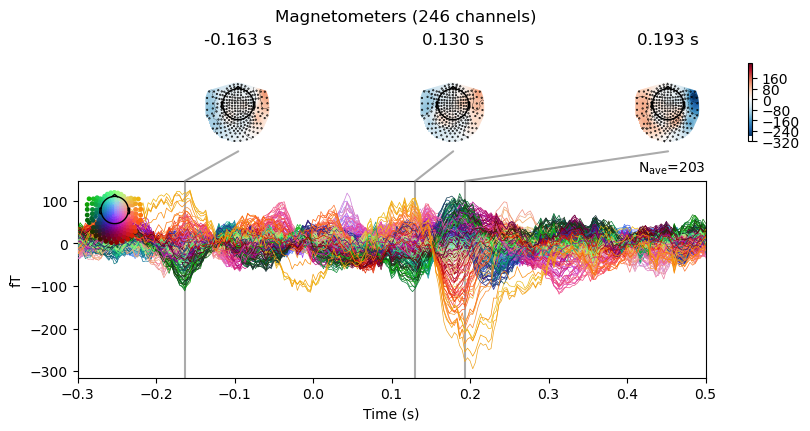

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 6.2e-12 (2.2e-16 eps * 246 dim * 1.1e+02  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 246 (0 small eigenvalues omitted)


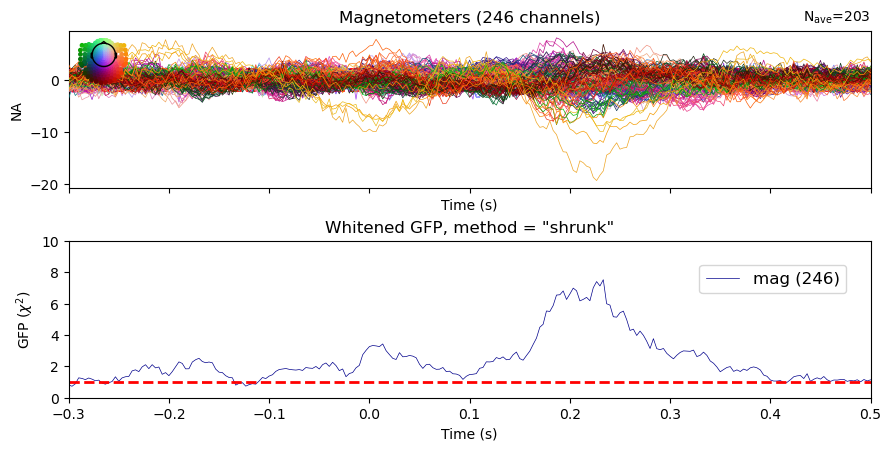

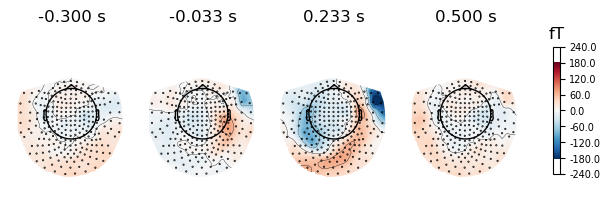

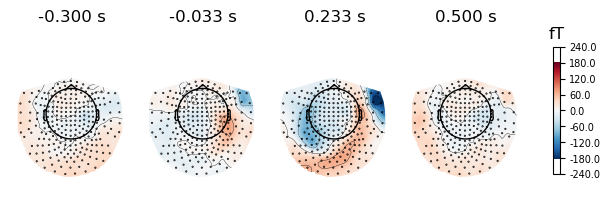

In [307]:
evoked_reading.plot_joint()
evoked_reading.plot_white(noise_cov)
evoked_reading.plot_topomap(ch_type="mag")

In [308]:
fwd = mne.make_forward_solution(
    evoked_reading.info,
    trans=morphed_trans,
    src=morphed_source, 
    bem=morphed_bem, 
    meg=True, 
    eeg=False
    )

Source space          : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_18_2/bem/scaled_fsaverage_BCOM_18_2-ico-5-src.fif
MRI -> head transform : /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/trans/BCOM_18_2-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_18_2/bem/scaled_fsaverage_BCOM_18_2-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/ciprianbangu/mne_data/MNE-fsaverage-data/scaled_fsaverage_BCOM_18_2/bem/scaled_fsaverage_BCOM_18_2-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999487 0.000643 -0.032008      -3.32 mm
    -0.001029 0.999927 -0.012061      25.53 mm
    0.031997 0.012088 0.999415      35.90 mm
    0.000000 0.000000 0.000000       1.00

Read 247 MEG channels from info
105 coil 

In [309]:
#create inverse operator
inverse_operator = mne.minimum_norm.make_inverse_operator(
    evoked_reading.info, 
    fwd, 
    noise_cov, 
    loose=0.2, #surface so this is equivalent to auto - weights the source variances of the dipole components parallel to cortical surface, 
    depth=0.8, #actually this is ignored for eLoreta; but determines the weight of the forward using depth prior
)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 246 channels.
    246 out of 247 channels remain after picking
Selected 246 channels
Creating the depth weighting matrix...
    246 magnetometer or axial gradiometer channels
    limit = 20345/20484 = 10.013201
    scale = 3.44174e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 6.2e-12 (2.2e-16 eps * 246 dim * 1.1e+02  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the

In [310]:
# applt inverse operator for all of the epochs
snr = 3.0 # idea that the signal is pretty noisy
lambda2 = 1.0/snr**2 # regularization parameter

stc = mne.minimum_norm.apply_inverse(
    evoked_reading,
    inverse_operator=inverse_operator,
    lambda2=lambda2,
    method='dSPM'
)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 203
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 246 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.06 × 52 + 0.06 × 16 + 0.06 × 34 + 0.07 × 42 + 0.03 × 24 + 0.08 × 12 + 0.03 × 56 + 0.05 × 36 + 0.06 × 14 + 0.02 × 54 + 0.07 × 26 + 0.03 × 66 + 0.09 × 32 + 0.04 × 44 + 0.06 × 46 + 0.05 × 62 + 0.05 × 64 + 0.07 × 22"...
    Picked 246 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  85.0% variance
    Combining the current components...
    dSPM...
[done]


In [333]:
brain = stc.plot(hemi='both')
brain.add_label(label=label, borders=True, color='red')

Using control points [ 4.70014797  5.49627016 12.16364199]


## Morph back to FSAverage for labels to match

In [312]:
morph = mne.compute_source_morph(
    src=inverse_operator['src'],
    subject_from=f"{scaled}_{subject}",#morphedfsaveragefoldername, i.e., fsaverage_scaled xxx 
    subject_to='fsaverage',
    # subjects_dir=,#saving directory?
)

morphed_stc = morph.apply(stc)

surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    2 smooth iterations done.
    2 smooth iterations done.
[done]
[done]


In [313]:
morphed_stc.plot(hemi='split')

Using control points [ 4.70014797  5.49627016 12.16364199]


In [320]:
# read labels from fsaverage annotation using aparc parcellation
labels = mne.read_labels_from_annot(
    subject='fsaverage', 
    parc='aparc.a2009s', 
    hemi='lh',
    subjects_dir=subjects_dir)
labels


Reading labels from parcellation...
   read 75 labels from /Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.a2009s.annot


[<Label | fsaverage, 'G_Ins_lg_and_S_cent_ins-lh', lh : 769 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Ant-lh', lh : 2171 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Mid-Ant-lh', lh : 1957 vertices>,
 <Label | fsaverage, 'G_and_S_cingul-Mid-Post-lh', lh : 2386 vertices>,
 <Label | fsaverage, 'G_and_S_frontomargin-lh', lh : 932 vertices>,
 <Label | fsaverage, 'G_and_S_occipital_inf-lh', lh : 1277 vertices>,
 <Label | fsaverage, 'G_and_S_paracentral-lh', lh : 2272 vertices>,
 <Label | fsaverage, 'G_and_S_subcentral-lh', lh : 2607 vertices>,
 <Label | fsaverage, 'G_and_S_transv_frontopol-lh', lh : 627 vertices>,
 <Label | fsaverage, 'G_cingul-Post-dorsal-lh', lh : 1098 vertices>,
 <Label | fsaverage, 'G_cingul-Post-ventral-lh', lh : 520 vertices>,
 <Label | fsaverage, 'G_cuneus-lh', lh : 1430 vertices>,
 <Label | fsaverage, 'G_front_inf-Opercular-lh', lh : 1800 vertices>,
 <Label | fsaverage, 'G_front_inf-Orbital-lh', lh : 453 vertices>,
 <Label | fsaverage, 'G_front_inf-Triangul

In [332]:
label = [label for label in labels if 'G_occipital_middle-lh' in label.name][0]
label

<Label | fsaverage, 'G_occipital_middle-lh', lh : 2098 vertices>

In [336]:
src = mne.read_source_spaces("/Users/ciprianbangu/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-5-src.fif")
label_time_courses = mne.extract_label_time_course(
    morphed_stc,
    label,
    src=src,
    mode='mean_flip',
    return_generator=False,
)

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Extracting time courses for 1 labels (mode: mean_flip)


In [384]:
import pywt
sampling_rate = 300 # data already downsampled to 300 at this point
log_samples = 100 # we want 100 coefficients
cwt_wavelet_name = 'cmor' # reconstruction wavelet
B = 1.0 # wavelet bandwith (higher means more frequencies at each scale, but less precision in peak timing)
C = 1.0 # central frequency (higher means more oscialltions per time window, meaning higher frequency features per scale)
cwt_wavelet = f'{cwt_wavelet_name}{B}-{C}'
frequencies = np.logspace(np.log10(1), np.log10(sampling_rate/2), log_samples)
sampling_period = 1/sampling_rate
scales = pywt.central_frequency(wavelet=cwt_wavelet)/ (frequencies * sampling_period)
dwt_wavelet_name='db4' # denoizing wavelet 
level=5 # level of decomposition. NB in Dash et al. they use 7, but our signal is shorter, so 5 is max
x = process_channel(
                    signal=label_time_courses,
                    cwt_wavelet=cwt_wavelet,
                    scales=scales,
                    sampling_period=sampling_period,
                    dwt_wavelet_name=dwt_wavelet_name,
                    level=level,
                    )

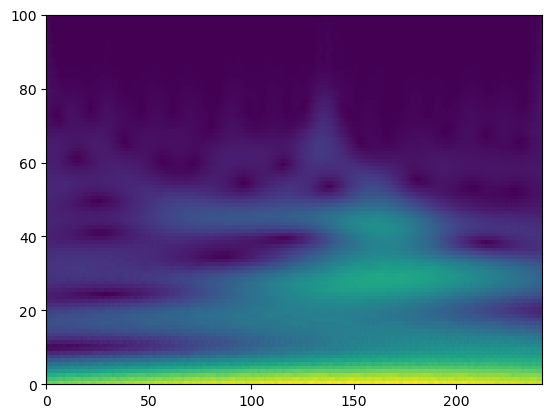

In [385]:
# Reshape x to a 2D array with shape (-1, x.shape[-1]) (flatten all but the last dimension)
x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
x = x.squeeze()
plt.pcolormesh(x)